# Introduction

Time series modeling is a hot topic in tech right now. Bridging the worlds of statistical modeling and machine learning, time series modeling allows one to model processes based on one thing: time. For the majority of the discipline's existence, stochastic models have dominated the methodology. Primarily, these include ARIMA and SARIMA models. While robust to many troublesome patterns found within your run of the mill time series, they can't solve everything. Parametric models, while accurate, always suffer from violated assumptions. One issue these models struggle with is non-constant variance, which was solved by Robert F. Engle's ARCH model $_{[1]}$. 

New innovations are still being made to solve the holes in these models. A 2017 research paper written by Hristos Tyralis and Georgia Papacharalampous $_{[2]}$ suggests that the use of random forest for variable selection produces better forecasts than their ACF and PACF derived counterparts.

In this project, we examine the BCG Jena Weather Station Dataset from 2017-2024 $_{[3]}$. Utilizing the methodology of Tyralis and Papacharalampous, we investigate the effectiveness of random forest-engineered time series models on weather in comparison to other contemporary methods.

# Data Processing

In [ ]:
import kagglehub
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

path = kagglehub.dataset_download("matthewjansen/bgc-jena-weather-station-dataset-20172024")
files = os.listdir(path)
csv_file = [file for file in files if file.endswith('.csv')]
dataset_path = os.path.join(path, csv_file[0])
df = pd.read_csv(dataset_path)
print(df)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       2017-01-01 00:10:00    999.77     -4.91    268.27        -8.41   
1       2017-01-01 00:20:00    999.63     -5.05    268.13        -8.37   
2       2017-01-01 00:30:00    999.54     -4.98    268.21        -8.38   
3       2017-01-01 00:40:00    999.40     -4.88    268.33        -8.56   
4       2017-01-01 00:50:00    999.17     -5.17    268.06        -8.74   
...                     ...       ...       ...       ...          ...   
420777  2024-12-31 23:20:00    997.74     -0.78    272.55        -2.64   
420778  2024-12-31 23:30:00    997.81     -1.42    271.90        -2.71   
420779  2024-12-31 23:40:00    997.88     -1.41    271.90        -2.80   
420780  2024-12-31 23:50:00    997.92     -1.63    271.68        -2.96   
420781  2025-01-01 00:00:00    997.51     -1.54    271.81        -3.00   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  \
0         76.3          4.24       

The BCG Jena Weather Station Dataset contains 22 measurements of weather related processes such as pressure, temperature, and namely, rainfall. For the sake of this project, we will be focussing on the rain measurements. In this particular dataset, rainfall is measured in 10 minute intervals. While informative, this scale doesn't present meaningful insights. Thus, we will convert the dataset to a month-by-month amount.

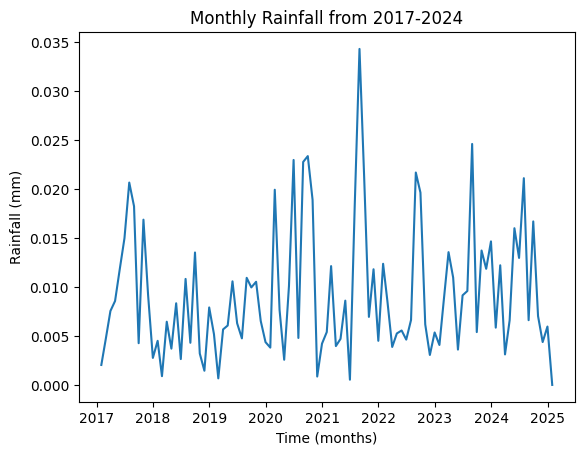

In [4]:
import pandas as pd

df = df[["Date Time", "rain (mm)"]]
df["datetime"] = pd.to_datetime(df["Date Time"])
df.set_index("datetime", inplace=True)
df = df["rain (mm)"].resample("ME").mean().to_frame(name="Rainfall")

plt.plot(df)
plt.xlabel("Time (months)")
plt.ylabel("Rainfall (mm)")
plt.title("Monthly Rainfall from 2017-2024")
plt.show()

# Feature Engineering

We will first proceed by creating feature variables for the random forest model. More specifically, we will create lagged vectors for the autoregressive component and rolling average vectors for the moving average component. We are utilizing the following naming scheme:

Autoregressive Components: $y_{(t-h)}$

Moving Average Components: $z_{(t-h)}$

where h is the lag.

In [5]:
df["y(t-1)"] = df["Rainfall"].shift(1)
df["y(t-2)"] = df["Rainfall"].shift(2)
df["y(t-3)"] = df["Rainfall"].shift(3)
df["y(t-6)"] = df["Rainfall"].shift(6)
df["y(t-12)"] = df["Rainfall"].shift(12)

df['z(t-1)'] = df['Rainfall'].rolling(window=1).mean()
df['z(t-2)'] = df['Rainfall'].rolling(window=2).mean()
df['z(t-3)'] = df['Rainfall'].rolling(window=3).mean()
df['z(t-6)'] = df['Rainfall'].rolling(window=6).mean()
df['z(t-12)'] = df['Rainfall'].rolling(window=12).mean()

print(df)

            Rainfall    y(t-1)    y(t-2)    y(t-3)    y(t-6)   y(t-12)  \
datetime                                                                 
2017-01-31  0.002039       NaN       NaN       NaN       NaN       NaN   
2017-02-28  0.004613  0.002039       NaN       NaN       NaN       NaN   
2017-03-31  0.007549  0.004613  0.002039       NaN       NaN       NaN   
2017-04-30  0.008565  0.007549  0.004613  0.002039       NaN       NaN   
2017-05-31  0.011873  0.008565  0.007549  0.004613       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-09-30  0.016690  0.006608  0.021102  0.012963  0.003114  0.005394   
2024-10-31  0.007034  0.016690  0.006608  0.021102  0.006597  0.013718   
2024-11-30  0.004375  0.007034  0.016690  0.006608  0.015995  0.011852   
2024-12-31  0.005959  0.004375  0.007034  0.016690  0.012963  0.014651   
2025-01-31  0.000000  0.005959  0.004375  0.007034  0.021102  0.005847   

              z(t-1)    z(t-2)    z(t

## Fitting RF Model

Tyralis and Papacharalampous suggest using 500 trees for the Random Forest model as a medium between Kuhn and Johnson $_{[4]}$, and Probst and Boulesteix $_{[5]}$, who suggest 1000 and 100 trees, respectively.

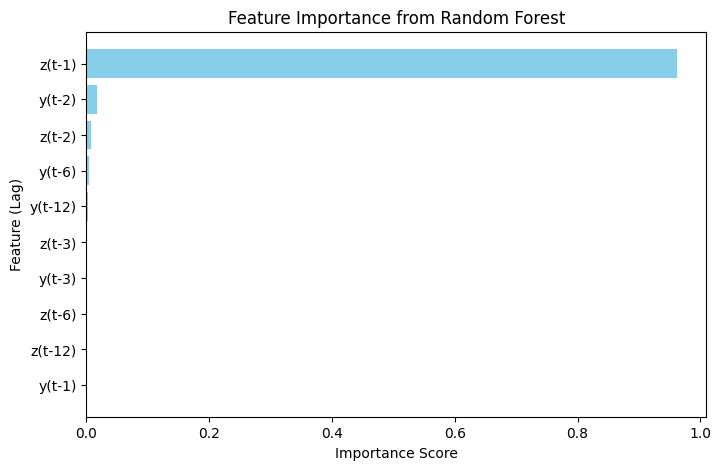

In [6]:
df.dropna(inplace=True)

X = df.drop("Rainfall", axis=1)
y = df["Rainfall"]

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature (Lag)")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()


The above plot depicts the results of the Random Forest model fit. We observe that it highly favors the lag 1 moving average component, with the lag 2 autoregressive and lag 2 moving average components holding a residual degree of importance. Thus, we will an MA(1) model.

## Fitting Time Series Models

We will now create training and testing sets with the cutoff beginning at the first of the final 12 months.

In [7]:
split_date = df.index[-12]

df_train = df.loc[:split_date]
df_test = df.loc[split_date:]

X_train, y_train = df_train.drop(columns=["Rainfall"]), df_train["Rainfall"]
X_test, y_test = df_test.drop(columns=["Rainfall"]), df_test["Rainfall"]

The training-testing split is visualized below.

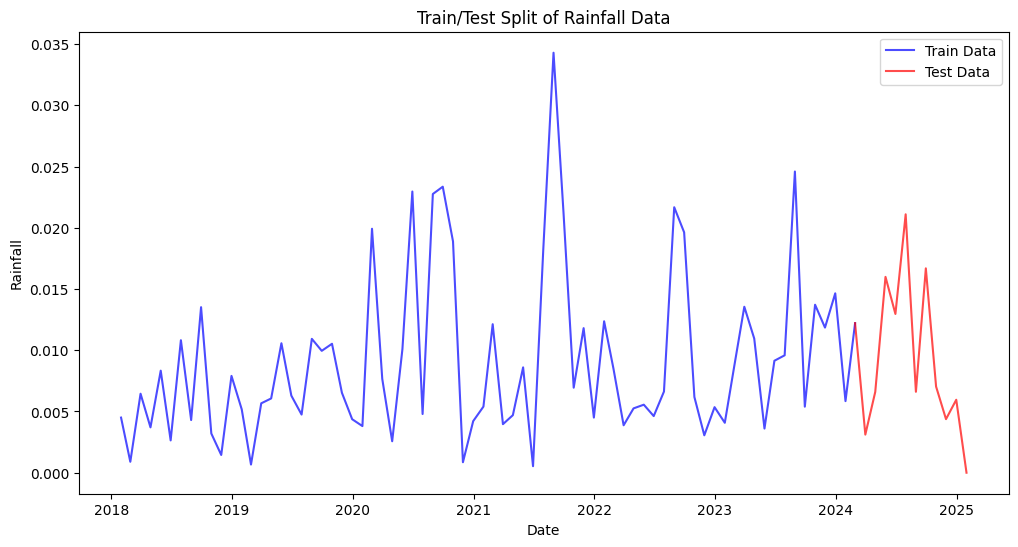

In [8]:
train_index = y_train.index
test_index = y_test.index

plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="blue", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Train/Test Split of Rainfall Data")
plt.legend()
plt.show()

# Random Forest Method

In [ ]:
ma_1 = ARIMA(y_train, order = (0,0,1)).fit()
rf_pred = ma_1.predict(n = len(y_test))

# Box-Jenkins Method

In [10]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# The time series plot is observed above, so we move to identify if 
# our data is stationary or not

monthly_means = df["Rainfall"]

def check_stationarity(series):
    """
    Purpose: Utilize ADF Testing to determine stationarity.

    Input: Time Series
    Output: Stationary statistics + Indication
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}\n")
    print(f"P-value:{result[1]}")
    if result[1] <= 0.05:
        print("Data is Stationary \n")
    else:
        print("Data is not Stationary, Differencing required. \n")
    # Test 1:
print("Stationarity Test (Monthly): \n")
check_stationarity(monthly_means)

# Data is stationary, check ACF and PACF
plot_acf(monthly_means)
plot_pacf(monthly_means)


# Model-Fitting Procedures
monthly_model = auto_arima(monthly_means,seasonal=False,trace=True,suppress_warnings=True,stepwise=True)

print("Test 1: Monthly Model Summary")
print(monthly_model.summary())
print("\n")

# Forecasting 
daily_forecast = monthly_model.predict(n_periods=12)
data_index = pd.date_range(start=monthly_model.index[-1],periods=12,freq="D")
daily_series_forecast = pd.Series(daily_forecast,index=data_index)

figure_data = pd.concat([monthly_model,daily_series_forecast])

plt.figure(figsize=(10,5))
plt.plot(figure_data[-50:-1],label="Monthly Series (1,0,0) Forecast")
plt.xlabel("Time (months))")
plt.ylabel("Rainfall(mm)")
plt.show()


ModuleNotFoundError: No module named 'pmdarima'

# Model Comparison

In [ ]:
rf_mse = mean_squared_error(rf_pred, y_test)
box_jenkins_mse = mean_squared_error(box_jenkins_pred, y_test)
auto_arima_mse = mean_squared_error(box_jenkins_pred, y_test)

## To-do

1. Getting title, names, date, etc. header organized for this file
2. ~~Decide on other models to compare to (eg. ARIMA, SARIMA, ARCH, etc.)~~
3. ~~Set up Random Forest Regressor (Brooks can do this)~~
4. ~~Set up other models~~
5. Decide on comparison metric (eg. MSE, RMSE, etc.)
6. Compare models

# References

1. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. The Econometric Society. https://doi.org/10.2307/1912773.

2. Tyralis, H., & Papacharalampous, G. (2017). Variable Selection in Time Series Forecasting Using Random Forests. Algorithms, 10(4), 114. https://doi.org/10.3390/a10040114

3. Jansen, M. (2024). BGC Jena weather station dataset (2017–2024) [Dataset]. Kaggle. https://www.kaggle.com/datasets/matthewjansen/bgc-jena-weather-station-dataset-20172024.

4. Kuhn, M.; Johnson, K. Applied Predictive Modeling; Springer: New York, NY, USA, 2013. [Google Scholar]

5. Probst, P.; Boulesteix, A.L. To tune or not to tune the number of trees in random forest? arXiv 2017, arXiv:1705.05654v1. [Google Scholar]